In [1]:
# Designs a 150 ns NOT gate (π rotation) that is robust against 
# time-dependent detuning and minimizes leakage into the |2⟩ state.

# Robustness is achieved by assuming a detuning of the form:
#             δ(t) = A·cos(2π·ω·t)
# and optimizing the gate over a grid of ω ∈ [0, 10 MHz] and 
# A ∈ [-5 MHz, 5 MHz] to ensure high fidelity across this range.

# The control pulse is decomposed into a Fourier series of the form:
#             Ωx(t) = 2π·ν_Ref · Σ an·sin((2n-1)·π·t/T)
#             Ωy(t) = 2π·ν_Ref · Σ bn·sin(2n·π·t/T)
# where n ∈ {1, 2, ..., 10}. The pulse amplitude is constrained such that
# (Ωx²+Ωy²)¹⸍² < 20 MHz.

# Estimated script runtime: ~15 minutes.

# AUTHOR:
#     Leo Van Damme / Technical University of Munich, 2025


In [2]:
from Module.parameters import ProblemParameters
from Module.grape import *
import matplotlib.pyplot as plt
from Module.pulse_utils import *
from Module.phys_utils import StateProbability, EigState, GateFidelityMap

In [3]:
# Pre-define the time to construct the detuning
Nt = 150               # Number of time steps
dt = 1e-9              # Time step in s
tc= np.arange(Nt)*dt   # Start of each time interval

# Number of sampling points along the specified ranges
Nw = 5                 # Number of sampling points along ω
NA = 5                 # Number of sampling points along A

# Frequency of the cosine ω in [0, 10 MHz] with Nw values
w = np.linspace(0,10e6,Nw)

# Amplitude of the cosine A in [-5 MHz, 5 MHz] with NA values
A=np.linspace(-5e6,5e6,Nw)

# Create a grid of parameters
wGrid, AGrid = np.meshgrid(w, A)  

# Reshape as vector (Nw*NA,1)
wVec = np.reshape(wGrid,(Nw*NA,1))
AVec = np.reshape(AGrid,(Nw*NA,1))

# Create full grid of time-dependent detunings of shape (Nw*NA, Nt)
Det = AVec*np.cos(2*np.pi*wVec*tc.reshape(1,Nt))

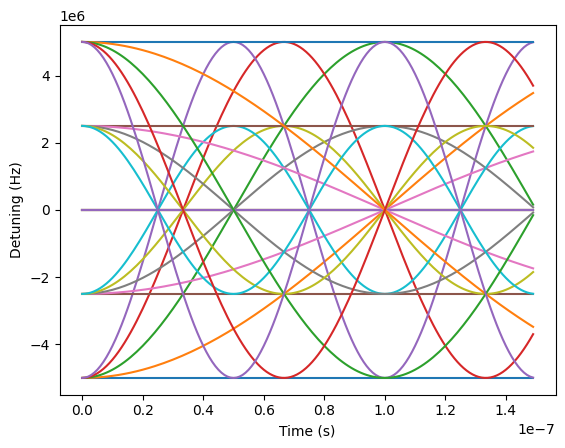

In [4]:
# Spagetti plot of the detuning map
plt.figure()
plt.plot(tc, Det.T)

# Labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Detuning (Hz)')

plt.show()


In [5]:
# Problem parameters
p = ProblemParameters(
                QubitFreq = 5e9 + Det,  # QubitFreq (+ detuning) in Hz
                CarrFreq = 5e9,         # Carrier frequency in Hz
                alpha = -100e6,         # Anharmonicity in Hz
                NLevels = 3,            # Number of energy levels
                dt = dt,                # Timestep in s.
                Nt = Nt,                # Number of time steps
                CompSpace = [0,1],      # Indices of the computational states
                Target = [[0, 1],       # Target gate
                          [1, 0]]
                )

In [6]:
# Define analytical basis for the pulse
Ncoeffs = 10
fx = FourierSym(p.Nt,Ncoeffs)      # Symmetric Fourier Harmonics (see pulse_utils)
fy = FourierAnt(p.Nt,Ncoeffs)      # Antisymmetric Fourier Harmonics
p.Set(uxBasis = fx, uyBasis = fy)  # Add to the list of parameters

In [7]:
# Initial guess: Random coefficients
ax0, ay0 = InitPulse(p,PulseType="CosDrag",ThetaTar=np.pi)

Initializing pulse...
Compiling cost function... Done.
Pulse initialized.


In [8]:
# Optimization options
gopt=Grape(
        Maxiter=2000,       # Maximum number of iterations
        MaxAmplitude=20e6,  # Maximum amplitude allowed in Hz
        nGrad=3             # Improve gradient accuracy
        )

In [9]:
# Optimize the pulse
ax, ay, J = gopt.Optimize(p,ax0, ay0)

Compiling cost function... Done.
########### OPTIMIZATION RESULTS ###########
Cost before optimization: 0.292136039567
Cost after optimization: 0.022922111151
Number of Iterations: 2000
Message: The maximum number of iterations has been reached


In [10]:
# Get the pulse shapes from the coefficients
ux = p.TruxBasis @ ax
uy = p.TruyBasis @ ay

# Get also the initial pulse shapes for later
ux0 = p.TruxBasis @ ax0
uy0 = p.TruyBasis @ ay0

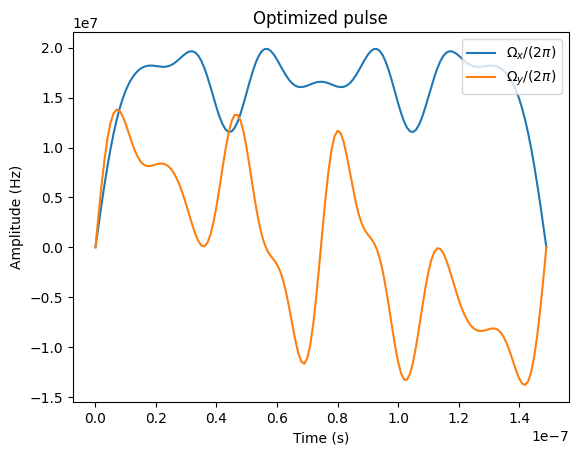

In [11]:
# Display In-phase and quadrature component in Hz
plt.figure()
plt.plot(p.tc, p.nuRef*ux, p.tc, p.nuRef*uy)

# Labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Hz)')
plt.legend([r'$\Omega_x/(2\pi)$', r'$\Omega_y/(2\pi)$'],
            loc='upper right')
plt.title(f"Optimized pulse")

plt.show()


In [12]:
# Compute transition probabilities
psi_init = EigState(StateIndice='|0>', NLevels=p.NLevels)
psi_meas = EigState(StateIndice='|1>', NLevels=p.NLevels)
P01 = StateProbability(p,ux,uy,InitState=psi_init, MeasState=psi_meas)

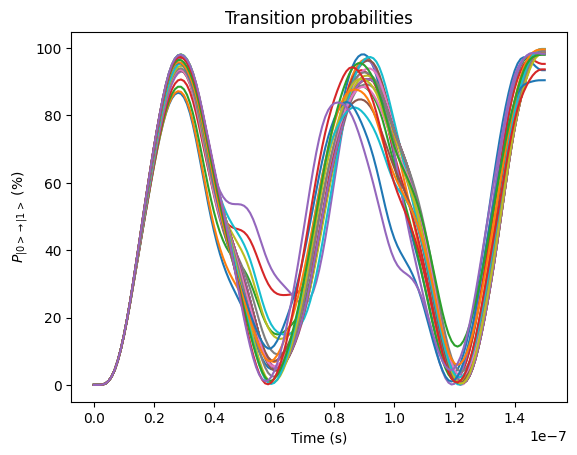

In [13]:
# Display Transition probabilities
plt.figure()
plt.plot(p.t,P01*100)
plt.xlabel('Time (s)')
plt.ylabel(r'$P_{|0>\rightarrow |1>}$ (%)')
plt.title("Transition probabilities")
plt.show()

In [14]:
# Extend the parameter map for better plots
Nw = 55 
NA = 55
w = np.linspace(0,12e6,Nw)
A=np.linspace(-7e6,7e6,Nw)
wGrid, AGrid = np.meshgrid(w, A)  
wVec = np.reshape(wGrid,(Nw*NA,1))
AVec = np.reshape(AGrid,(Nw*NA,1))
Det = AVec*np.cos(2*np.pi*wVec*tc.reshape(1,Nt))
p.Set(QubitFreq = 5e9 + Det)

In [15]:
# Compute the vectorized fidelity map
F0 = GateFidelityMap(p,ux0,uy0)
F = GateFidelityMap(p,ux,uy)

Computation of the gate fidelity map 3025/3025
Computation of the gate fidelity map 3025/3025


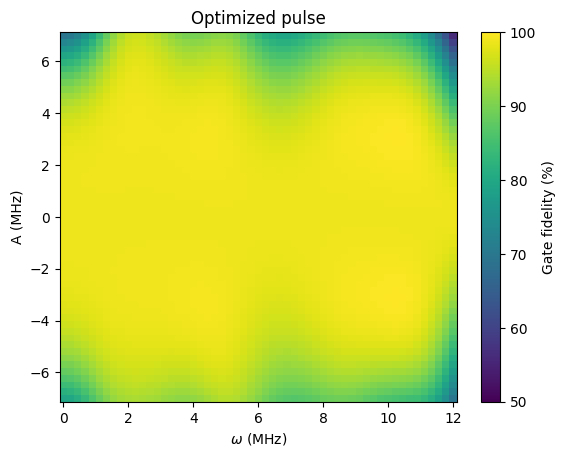

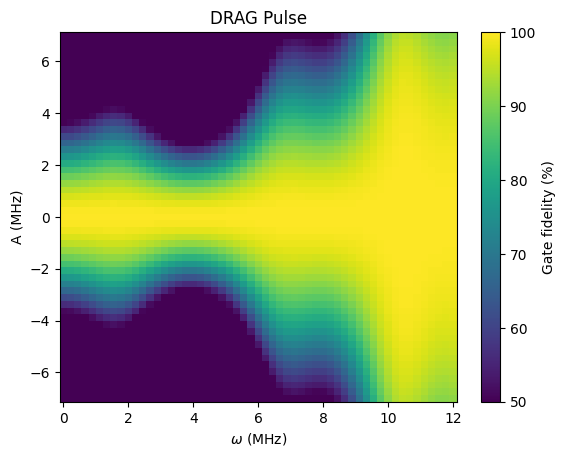

In [16]:
# Display the result
FMap = F.reshape((Nw,NA))
plt.pcolormesh(wGrid/1e6, AGrid/1e6, FMap*100, shading='auto', vmin=50, vmax=100)
plt.colorbar(label='Gate fidelity (%)')
plt.xlabel(r'$\omega$ (MHz)')
plt.ylabel(r'A (MHz)')
plt.title("Optimized pulse")
plt.show()

F0Map = F0.reshape((Nw,NA))
plt.pcolormesh(wGrid/1e6, AGrid/1e6, F0Map*100, shading='auto', vmin=50, vmax=100)
plt.colorbar(label='Gate fidelity (%)')
plt.xlabel(r'$\omega$ (MHz)')
plt.ylabel(r'A (MHz)')
plt.title("DRAG Pulse")
plt.show()